In [7]:
import cv2
import matplotlib.pylab as plt
from PIL import Image
import numpy as np
import math
from skimage.exposure import rescale_intensity
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.3.1'

In [3]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# CNNs Building blocks



Siguiendo con los visto en el notebook anterior, es normal tener que definir manualmente estos kernels cuando estamos trabajando con procesamiento de imágenes. De hecho, puedes que ya estés familiarizado con algunos de ellos, dado que muchos de los software de edición fotográfica como Photoshop, CorelDRAW etc. usan este tipo de operaciones por debajo para realizar el suavizado de la imagen, disminuir el efecto del ruido, resaltar los bordes y mejorara la calidad. Sin embargo en el contexto de ML y DL, resulta natural preguntarse: ¿hay alguna manera de aprender automáticamente este tipo de filtros?, o incluso ¿Se podrían utilizar estos filtros para hacer clasificación de imágenes y detección de objetos?. La buena noticia es que la respuesta a estas preguntas es SI!!, en este notebook aprenderás sobre las capas en las redes neuronales convolucionales que se encargan de llevar a cabo dichas tareas (Buscar y aprender patrones en las imágenes usando convoluciones).

Iniciemos entonces hablando de nuevo sobre los kernels y como se llevan a cabo las convoluciones sobre la imagen. Repasemos el siguiente ejemplo numérico:

$$
O_{i, j}=\frac{1}{9}\left[\begin{array}{lll}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{array}\right] \star\left[\begin{array}{ccc}
93 & 139 & 101 \\
26 & 252 & 196 \\
135 & 230 & 18
\end{array}\right]=\left[\begin{array}{ccc}
1 / 9 \times 93 & 1 / 9 \times 139 & 1 / 9 \times 101 \\
1 / 9 \times 26 & 1 / 9 \times 252 & 1 / 9 \times 196 \\
1 / 9 \times 135 & 1 / 9 \times 230 & 1 / 9 \times 18
\end{array}\right]
$$

Así tenemos que,

$$
O_{i, j}=\sum\left[\begin{array}{ccc}
10.3 & 15.4 & 11.2 \\
2.8 & 28.0 & 21.7 \\
15.0 & 25.5 & 2.0
\end{array}\right] \approx 132
$$


Luego de aplicar esta convolución sobre la imagen de entrada, el valor del pixel en la coordenada (i,j) de la imagen de salida será $O_{i,j} = 132$

Si aplicamos esta operación sobre toda la imagen, notaremos que en la imagen de salida hay un cambio en las dimensiones de la misma. A que se debe ello?. Bueno, Si recordamos en la función convolve que implementamos en el notebook anterior, para poder aplicar los diferentes filtros(kernels) sobre la imagen, se agrego un borde sobre la misma para garantizar que obtendríamos un nuevo valor para cada píxel (x,y). Esto se debe a que para los pixeles definidos sobre la margen de la imagen no tenemos una región cuadrada con los pixeles vecinos. Este posicionamiento implica que no existe el "centro" para aquellos píxeles que caen a lo largo del borde de la imagen.

![Padding](./images/padding.jpeg)

<img src="images/kernel.png" width="500px" />

- En el modo `full`, el parámetro de relleno p se establece en p = m - 1. El relleno completo aumenta las dimensiones de la salida; por lo tanto, rara vez se usa en arquitecturas de redes neuronales convolucionales.
- El mode `same` es usado si se desea que el tamaño de la imagen de salida sea el mismo que el de la imagen de entrada. En este caso, el parámetro de relleno p se calcula de acuerdo con el tamaño del filtro, junto con el requisito de que el tamaño de entrada y el tamaño de salida sean los mismos.
- Finalmente, el modo `valid` se refiere al caso donde p = 0 (sin relleno).

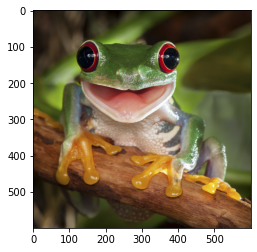

In [54]:
size = 800, 600
img = Image.open("images/happy-frog.jpg")
img.thumbnail(size, Image.ANTIALIAS)
img = np.array(img) / 255.
plt.imshow(img)
plt.show()

In [55]:
img_tf = tf.convert_to_tensor(img, dtype=tf.float32)
img_tf = tf.expand_dims(img_tf, axis=0)
img_tf.shape

TensorShape([1, 600, 600, 3])

In [56]:
num_filters = 8
cnn_layer = layers.Conv2D(filters=num_filters, kernel_size=3, input_shape=(600,600,3))
cnn_layer_out = cnn_layer(img_tf)
print(cnn_layer_out.shape)
weights, bias = cnn_layer.weights
print(weights.shape)
print(bias)

(1, 598, 598, 8)
(3, 3, 3, 8)
<tf.Variable 'conv2d_15/bias:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>


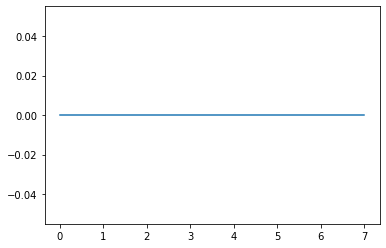

In [57]:
plt.plot(bias.numpy())
plt.show()

[[[-0.06513134  0.1424914  -0.13849741]
  [ 0.15268278 -0.15313777 -0.09683646]
  [-0.16033374 -0.1703515  -0.18002507]]

 [[-0.02978909 -0.17267063  0.04102793]
  [ 0.1862576   0.14108837 -0.12814903]
  [-0.23835787  0.17303672  0.08476433]]

 [[ 0.20887017 -0.07585214  0.01607063]
  [ 0.09304219  0.05492735  0.09594694]
  [-0.13402341 -0.22737336 -0.0891767 ]]]
[[[ 0.17998868  0.2355687  -0.00903837]
  [-0.053343   -0.1893193  -0.24582835]
  [ 0.03367907 -0.185841   -0.00282368]]

 [[ 0.1998274   0.09499839 -0.04096712]
  [-0.14005369  0.1902535   0.15332788]
  [-0.05504344 -0.06106457  0.03703541]]

 [[-0.10842459  0.08587554 -0.1423567 ]
  [-0.02592552 -0.20651077 -0.20555735]
  [ 0.08597028  0.199312    0.13590845]]]
[[[ 0.23376167  0.19940525 -0.05769861]
  [ 0.13269475 -0.11918142  0.19396544]
  [-0.06870802  0.0978187   0.185256  ]]

 [[ 0.1712091  -0.05817075  0.1378105 ]
  [-0.1575579   0.20711651  0.1965101 ]
  [-0.17466947 -0.12000492  0.16919586]]

 [[-0.07676114  0.201320

<Figure size 720x360 with 0 Axes>

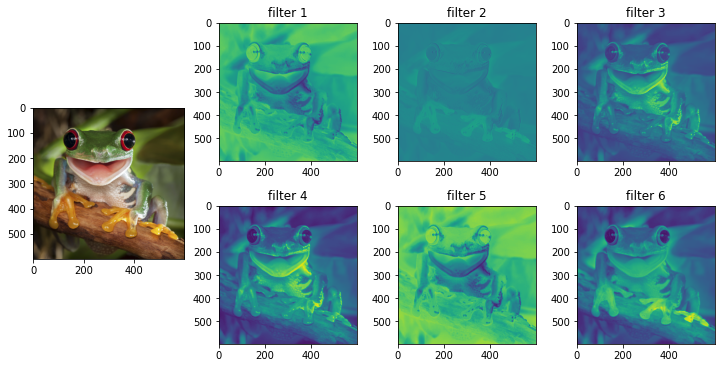

In [114]:
import matplotlib.gridspec as gridspec
import math

features_maps = cnn_layer_out.numpy()
features_maps = np.squeeze(features_maps)
weights, bias = cnn_layer.weights
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
n_cols = 3
n_cols+=1 # first column to show the image
n_rows = math.ceil(num_filters / n_cols)

fig = plt.figure(constrained_layout=True, figsize=(10, 5))
spec = gridspec.GridSpec(ncols=n_cols, nrows=n_rows, figure=fig)
ax = fig.add_subplot(spec[:,0])
ax.imshow(img)
i = 0
for row in range(n_rows):
    for col in range(1, n_cols):
        ax = fig.add_subplot(spec[row,col])
        fmap = features_maps[:,:,i]        
        kernel = weights[:,:,:,i].numpy()        
        print(kernel)
        ax.set_title(f"filter {i+1}")
        ax.imshow(fmap)
        i+=1
plt.show()

 ## Pooling (POOL)
 
La capa de pooling (POOL) es una operación de submuestreo, que normalmente se aplica después de una capa de convolución, que realiza cierta invariancia espacial. En particular, las max and average pooling layers son tipos especiales de agrupación en los que se toman el valor máximo y medio, respectivamente.

Contenido tomado de: [Convolutional Neural Networks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

![Pooling layers](images/pooling_layers.png)

# Fully Connected (FC)

Las fully connected layers(FC) reciben como entrada los features maps como un flatten vector, estás por lo general están conectadas a otras, dense layers para las cuales se cumple que cada salida se conecta a todas las neuronas de la siguiente capa. Se encuentran generalmente hacia el final de las arquitecturas CNN y se pueden usar para optimizar objetivos tales como puntajes de clase.

Contenido tomado de: [Convolutional Neural Networks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

![Pooling layers](images/fully-connected.png)

# Número de parametros

![Parameters](images/parameters.png)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               31490176  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              